In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-02-26 02:02:37.536756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 02:02:38.527626: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ines/anaconda3/envs/tf/lib/
2023-02-26 02:02:38.527740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ines/anaconda3/envs/tf/lib/
2023-02-26 02:02:38.527749: W tensorflow/compiler/tf2tensorr

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage", shuffle = True, image_size = (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


2023-02-26 02:02:57.334761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-26 02:02:57.334794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fedora): /proc/driver/nvidia/version does not exist
2023-02-26 02:02:57.335166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 1 0 1 1 0 1 0 0 1 1 2 1 0 0 0 0 1 0 0 1 0 0 1 2 1 1 2 0 0 0]


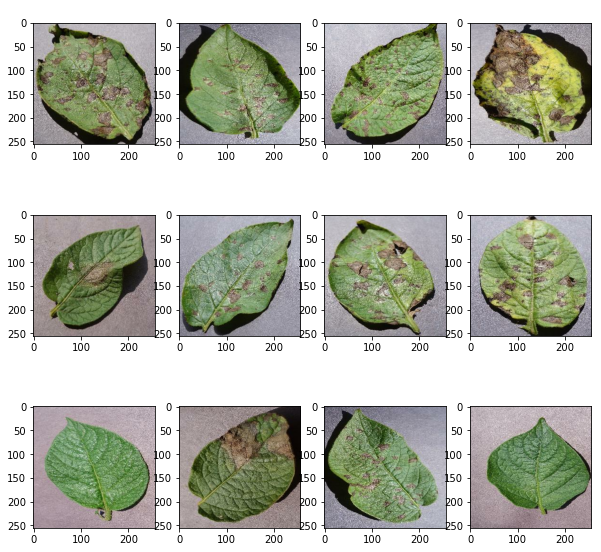

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]], color = "w")
        

In [8]:
#do validation at the end of every epoch. After all epochs do test
#train test split not available on tf => dataset.take

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
#slicing
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [25]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(.2)
])

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32,(3,3),activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [32]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=["accuracy"])

In [33]:
history = model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

Epoch 1/5


2023-02-26 02:22:42.886113: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 264257536 exceeds 10% of free system memory.
2023-02-26 02:22:43.005308: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 128000000 exceeds 10% of free system memory.
2023-02-26 02:22:43.341516: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 128000000 exceeds 10% of free system memory.
2023-02-26 02:22:43.797822: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 132128768 exceeds 10% of free system memory.
2023-02-26 02:22:43.797882: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 264257536 exceeds 10% of free system memory.


54/54 [==============================] - 72s 1s/step - loss: 0.8973 - accuracy: 0.5058 - val_loss: 0.8051 - val_accuracy: 0.4844
Epoch 2/5
54/54 [==============================] - 63s 1s/step - loss: 0.5970 - accuracy: 0.7274 - val_loss: 0.4618 - val_accuracy: 0.7865
Epoch 3/5
54/54 [==============================] - 64s 1s/step - loss: 0.3697 - accuracy: 0.8466 - val_loss: 0.2569 - val_accuracy: 0.8854
Epoch 4/5
54/54 [==============================] - 64s 1s/step - loss: 0.2558 - accuracy: 0.9062 - val_loss: 0.3130 - val_accuracy: 0.8438
Epoch 5/5
54/54 [==============================] - 65s 1s/step - loss: 0.2306 - accuracy: 0.9126 - val_loss: 0.2184 - val_accuracy: 0.9115


In [34]:
model.evaluate(test_ds)

8/8 [==============================] - 3s 224ms/step - loss: 0.1385 - accuracy: 0.9375


[0.1384948194026947, 0.9375]

In [35]:
history

In [36]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

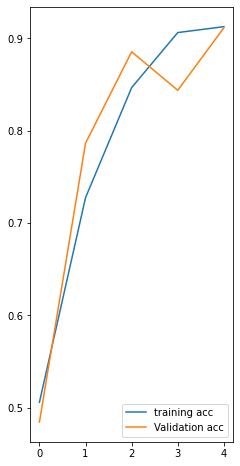

In [37]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), history.history["accuracy"], label='training acc')
plt.plot(range(EPOCHS), history.history["val_accuracy"], label='Validation acc')
plt.legend(loc="lower right")

Potato___Early_blight
1/1 [==============================] - 0s 220ms/step
0


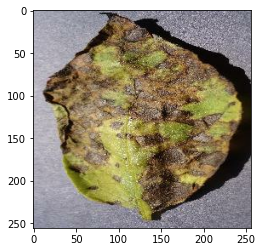

In [42]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    f_img = image_batch[0].numpy().astype("uint8")
    f_label = labels_batch[0]
    plt.imshow(f_img)
    print(class_names[f_label])
    batch_pred = model.predict(image_batch)
    print(np.argmax(batch_pred[0]))

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create batch
    pred = model.predict(img_array)
    pred_class = class_names[np.argmax(pred[0])]
    confidence = round(100*(np.max(pred[0])), 2)
    return pred_class, confidence

1/1 [==============================] - 0s 72ms/step


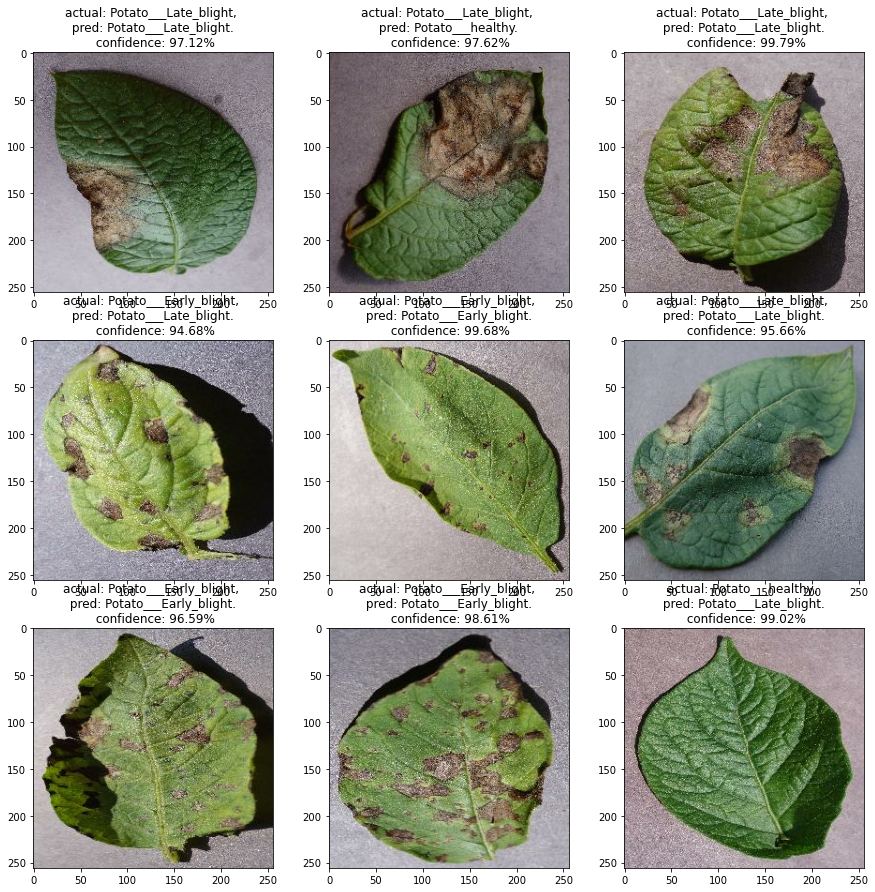

In [58]:
plt.figure(figsize=(15,15))
for imgs, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(imgs[i].numpy().astype("uint8"))
        pred_class, confidence = predict(model, imgs[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"actual: {actual_class}, \n pred: {pred_class}. \n confidence: {confidence}%")

In [60]:
model_version = 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets


tf.keras.backend.clear_session()